# Customer Churn Prediction Using Supervised Learning

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [2]:
# 2. Load Dataset
df = pd.read_csv('./Telco-Customer-Churn-Dataset.csv')

In [3]:
# 3. Drop irrelevant columns
df.drop('customerID', axis=1, inplace=True)

In [4]:
# 4. Convert target variable to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [5]:
# 5. Handle missing or bad data in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [6]:
# 6. One-hot encode categorical variables (drop_first to avoid dummy trap)
df = pd.get_dummies(df, drop_first=True)

In [7]:
# 7. Define features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [8]:
# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
# 9. Standardize features for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# 10. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True)
}

In [11]:
# 11. Train models
trained_models = {}

for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)
    trained_models[name] = model

In [12]:
# 12. Evaluation function
def evaluate_model(name, model, X_test, y_test):
    if name in ["Logistic Regression", "SVM"]:
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

In [13]:
# 13. Evaluate all models
results = {}

for name, model in trained_models.items():
    results[name] = evaluate_model(name, model, X_test, y_test)

results_df = pd.DataFrame(results).T.sort_values(by="F1 Score", ascending=False)
print("\nModel Evaluation Results:")
print(results_df)


Model Evaluation Results:
                     Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression  0.806955   0.658385  0.566845  0.609195  0.841585
SVM                  0.792761   0.644366  0.489305  0.556231  0.796047
Random Forest        0.786373   0.623729  0.491979  0.550075  0.825081


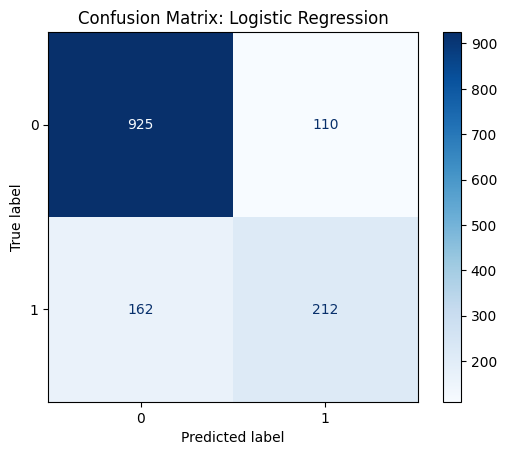

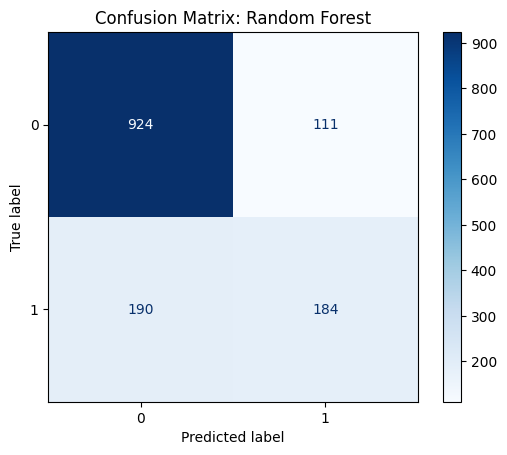

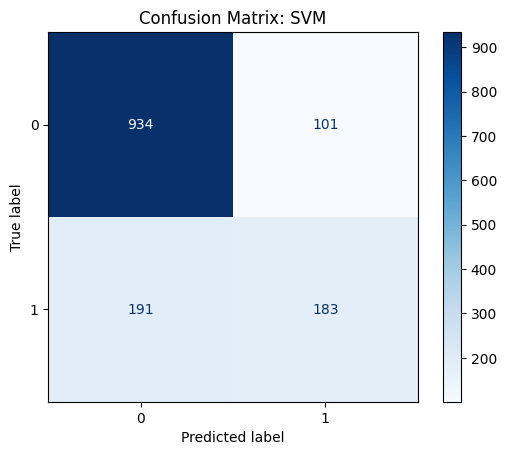

In [14]:
# 14. Confusion Matrices and Save Plots
os.makedirs("plots", exist_ok=True)

for name, model in trained_models.items():
    if name in ["Logistic Regression", "SVM"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')

    filename = f"plots/confusion_matrix_{name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()